<a href="https://colab.research.google.com/github/jhwnoh/UST2024Fall_MaterialsInformatics/blob/main/2024Fall_TestBasedGM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 22.1 MB/s eta 0:00:00


In [11]:
import rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import MolFromSmiles,MolToSmiles
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

class MolData(Dataset):
    def __init__(self,smis,toks):
        self.smis = smis
        self.toks = toks + ['<','>'] #'<'; start of sequence, '>'; end of sequence
        self.Ntok = len(toks)
        self.Nmax = 60

    def __len__(self):
        return len(self.smis)

    def __getitem__(self,idx):
        smi = '<'+self.smis[idx]+'>'
        smi += '>'*(self.Nmax-len(smi))

        x_all = np.array([self.toks.index(s) for s in smi]).flatten()

        x = x_all[:-1] #input
        y = x_all[1:] #output

        x = torch.LongTensor(x)
        y = torch.LongTensor(y)
        return x,y

class CharRNN(nn.Module):
    def __init__(self,dim_x0,dim_x1,dim_h,n_layer,d_ratio):
        super(CharRNN,self).__init__()
        self.n_layer = n_layer
        self.emb_layer = nn.Embedding(dim_x0,dim_x1)

        self.rnn = nn.GRU(dim_x1,dim_h,
                          num_layers=n_layer,
                          dropout = d_ratio,
                          batch_first = True)

        self.out = nn.Sequential(
                        nn.Linear(dim_h,dim_h),
                        nn.ReLU(),
                        nn.Linear(dim_h,dim_x0))

    def forward(self,x_in,h0=None):
        x0 = self.emb_layer(x_in)
        x1,h1 = self.rnn(x0,h0)
        x2 = self.out(x1)
        return x2,h1

In [12]:
def Sampling(sampler,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
        inits = torch.LongTensor([26]*n_sample).cuda()
        loader = DataLoader(inits,batch_size=50)

        Sampled = []
        for inp in tqdm(loader):
            x_in = inp.reshape(-1,1)

            x_hat = []
            h = None
            for seq_iter in range(max_len):
                out,h = sampler(x_in,h)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)

    Sampled = np.vstack(Sampled)

    Mols = []
    for s in Sampled:
        n_end = np.sum(s==27)

        if n_end == 0:
            continue

        n = np.min(np.where(s==27)[0])
        m = ''.join(tok_lib[s[:n]].tolist())
        Mols.append(m)

    Vals = []
    for smi in Mols:
        mol = MolFromSmiles(smi)
        if not mol is None:
            Vals.append(MolToSmiles(mol))

    Uni = list(set(Vals))

    return Vals,len(Vals),len(Uni)

In [14]:
import numpy as np
import pandas as pd
import os

import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

df = pd.read_csv('https://media.githubusercontent.com/media/molecularsets/moses/master/data/train.csv') #본인이 가진 파일 경로로 수정
smi_ = list(df.SMILES)

toks = list(set(''.join(smi_)))

np.random.seed(1)
np.random.shuffle(smi_)

n_train = 1000000
n_val = 100000

smi_train = smi_[:n_train]
smi_val = smi_[n_train:n_train+n_val]

batch_size = 64

train_data = MolData(smi_train,toks)
tok_lib = np.array(train_data.toks) # For sampling
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

model = CharRNN(28,128,480,3,0.2).cuda()

lr = 1e-4
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

num_epoch = 20
max_norm = 5
num_iter = 0

model.train()
for ep in range(num_epoch):
    for inp in tqdm(train_loader):
        x_in = inp[0].cuda()
        tgt = inp[1].cuda()

        x_out,_ = model(x_in)

        loss = ce_loss(x_out.reshape(-1,28),tgt.view(-1))

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        num_iter += 1

        if num_iter % 1000 == 0:
            mols,val,uniq = Sampling(model,200,100,tok_lib) #200: 샘플링 시도 횟수, 100: 최대 SMILES 길이
            print(ep,mols[0],num_iter,val,uniq)

            model.train()

  6%|▋         | 1005/15625 [00:41<18:39, 13.05it/s]

0 COc1cn(C)c(OC)ccc2[nH]c-2ncn1 1000 37 37


 13%|█▎        | 2005/15625 [01:22<13:41, 16.58it/s]

0 Cc1ccc(CNC2CCOCN(C(C)(C)C)C2)c(Cl)c1 2000 64 64


 19%|█▉        | 3004/15625 [02:03<13:50, 15.20it/s]

0 CC(=O)NC1CCC(C(=O)NC(C)C)(C(=O)NC2CC2)C1O 3000 84 84


 26%|██▌       | 4004/15625 [02:43<12:10, 15.92it/s]

0 Cc1nnc(NC(=O)c2cccc(N)c2)[nH]c1=O 4000 126 126


 29%|██▉       | 4579/15625 [03:07<07:31, 24.47it/s]


KeyboardInterrupt: 

In [15]:
mols,val,uniq = Sampling(model,1000,100,tok_lib) #1000: 샘플링 시도 횟수, 100: 최대 SMILES 길이

100%|██████████| 20/20 [00:01<00:00, 10.66it/s]


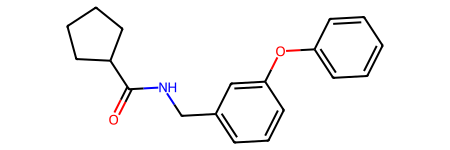

In [16]:
MolFromSmiles(mols[0])

(array([  5.,   9.,  33., 102., 141., 163., 155.,  44.,  20.,   6.]),
 array([18. , 21.3, 24.6, 27.9, 31.2, 34.5, 37.8, 41.1, 44.4, 47.7, 51. ]),
 <BarContainer object of 10 artists>)

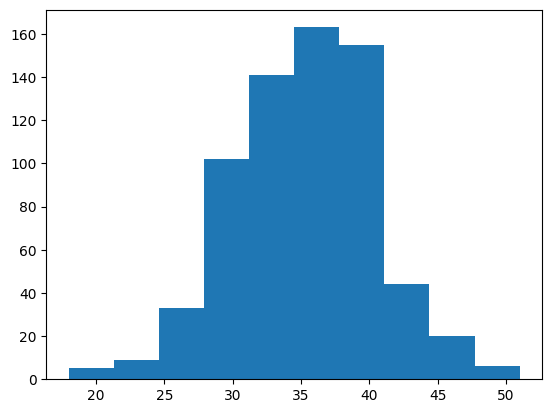

In [17]:
mol_size = [len(smi) for smi in mols]
import matplotlib.pyplot as plt
plt.hist(mol_size)